<a href="https://colab.research.google.com/github/Kryptera-K/STX-EMA-LinReg-Rising-Strategy/blob/main/STX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "STX"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("STX_clean.csv", index=False)
df

/tmp/ipython-input-2760245454.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2002-12-11,5.298223,5.528580,5.183044,5.298223,36719700
2002-12-12,5.150795,5.339688,5.077081,5.298224,9195600
2002-12-13,5.261364,5.298222,5.044828,5.113936,7739400
2002-12-16,5.348903,5.353510,5.127760,5.215295,3836400
2002-12-17,5.298223,5.427223,5.275187,5.344294,2729900
...,...,...,...,...,...
2025-10-21,214.570007,216.529999,210.679993,212.630005,2817500
2025-10-22,215.050003,219.320007,209.000000,213.669998,2925200
2025-10-23,226.410004,226.910004,218.250000,218.250000,2569600


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

CCI_LEVEL = 0
CCI_PERIOD = 14
CCI_SHIFT = 5
CCI_SHIFT_2 = 10
EMA_PERIOD = 20
EMA_SHIFT = 5
LINREG_PERIOD = 14
LINREG_SHIFT = 5
RSI_OVERBOUGHT_LEVEL = 70
RSI_OVERSOLD_LEVEL = 30
RSI_PERIOD = 14
RSI_SHIFT = 5
RSI_SHIFT_2 = 10

# -------------------------
# Indicator Functions
# -------------------------

def close_above_ema(df, period=EMA_PERIOD):
    df = calculate_ema(df, period)
    return df['Close'] > df['EMA']


def calculate_ema(df, period=EMA_PERIOD):
    """
    Calculate Exponential Moving Average (EMA) of the Close price.
    """
    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    return df


def linreg_rising(df, shift=LINREG_SHIFT, period=LINREG_PERIOD):
    df = df.copy()
    df['LinReg'] = calculate_linreg(df['Close'], period)
    return df['LinReg'] > df['LinReg'].shift(shift)


from sklearn.linear_model import LinearRegression
def calculate_linreg(series, period=LINREG_PERIOD):
    """
    Calculate Linear Regression value for each bar.
    """
    linreg_values = [np.nan] * len(series)
    for i in range(period - 1, len(series)):
        y = series[i - period + 1:i + 1].values.reshape(-1, 1)
        x = np.arange(period).reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        linreg_values[i] = model.predict([[period - 1]])[0][0]
    return pd.Series(linreg_values, index=series.index)


def rsi_change_upward(df, shift=RSI_SHIFT, shift2=RSI_SHIFT_2):
    df = calculate_rsi(df)
    df['RSI_Previous'] = df['RSI'].shift(shift)
    return (df['RSI'] > df['RSI_Previous']) & (df['RSI_Previous'] <= df['RSI_Previous'].shift(shift2))


def calculate_rsi(df, period=RSI_PERIOD):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()
    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df


def cci_rising(df, period=CCI_PERIOD, shifts=CCI_SHIFT):
    df['CCI_main'] = calculate_cci(df, period)['CCI']
    return df['CCI_main'] > df['CCI_main'].shift(shifts)


def calculate_cci(df, period=CCI_PERIOD):
    """
    Calculate Commodity Channel Index (CCI).
    """
    df = df.copy()
    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    # SMA of TP
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    # Mean Deviation
    df['MeanDev'] = df['TP'].rolling(period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    # CCI
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df



# -------------------------
# Entry conditions
# -------------------------

df["EMA_Close_Above"] = close_above_ema(df)
df["LinReg_Rising"] = linreg_rising(df)

# -------------------------
# Exit conditions
# -------------------------

df["RSI_Change_Upward"] = rsi_change_upward(df)
df["CCI_Rising"] = cci_rising(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'EMA_Close_Above',
    'LinReg_Rising',
]
exit_conditions = [
    'RSI_Change_Upward',
    'CCI_Rising',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------

shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                         2002-12-11 00:00:00
End                           2025-10-27 00:00:00
Period                         5756 days 00:00:00
Start Value                              100000.0
End Value                            5262609.2657
Total Return [%]                      5162.609266
Benchmark Return [%]                  4454.923843
Max Gross Exposure [%]                      100.0
Total Fees Paid                     520354.288481
Max Drawdown [%]                        61.484064
Max Drawdown Duration          1047 days 00:00:00
Total Trades                                  185
Total Closed Trades                           185
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            51.351351
Best Trade [%]                           88.15675
Worst Trade [%]                        -32.298269
Avg Winning Trade [%]                   12.980092
Avg Losing Trade [%]                    -7.088186


In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2002-12-11 00:00:00
End                           2025-10-27 00:00:00
Period                         5756 days 00:00:00
Start Value                              100000.0
End Value                          4554923.843358
Total Return [%]                      4454.923843
Benchmark Return [%]                  4454.923843
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        88.866618
Max Drawdown Duration          2094 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     4454923.843358
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-468269411.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True



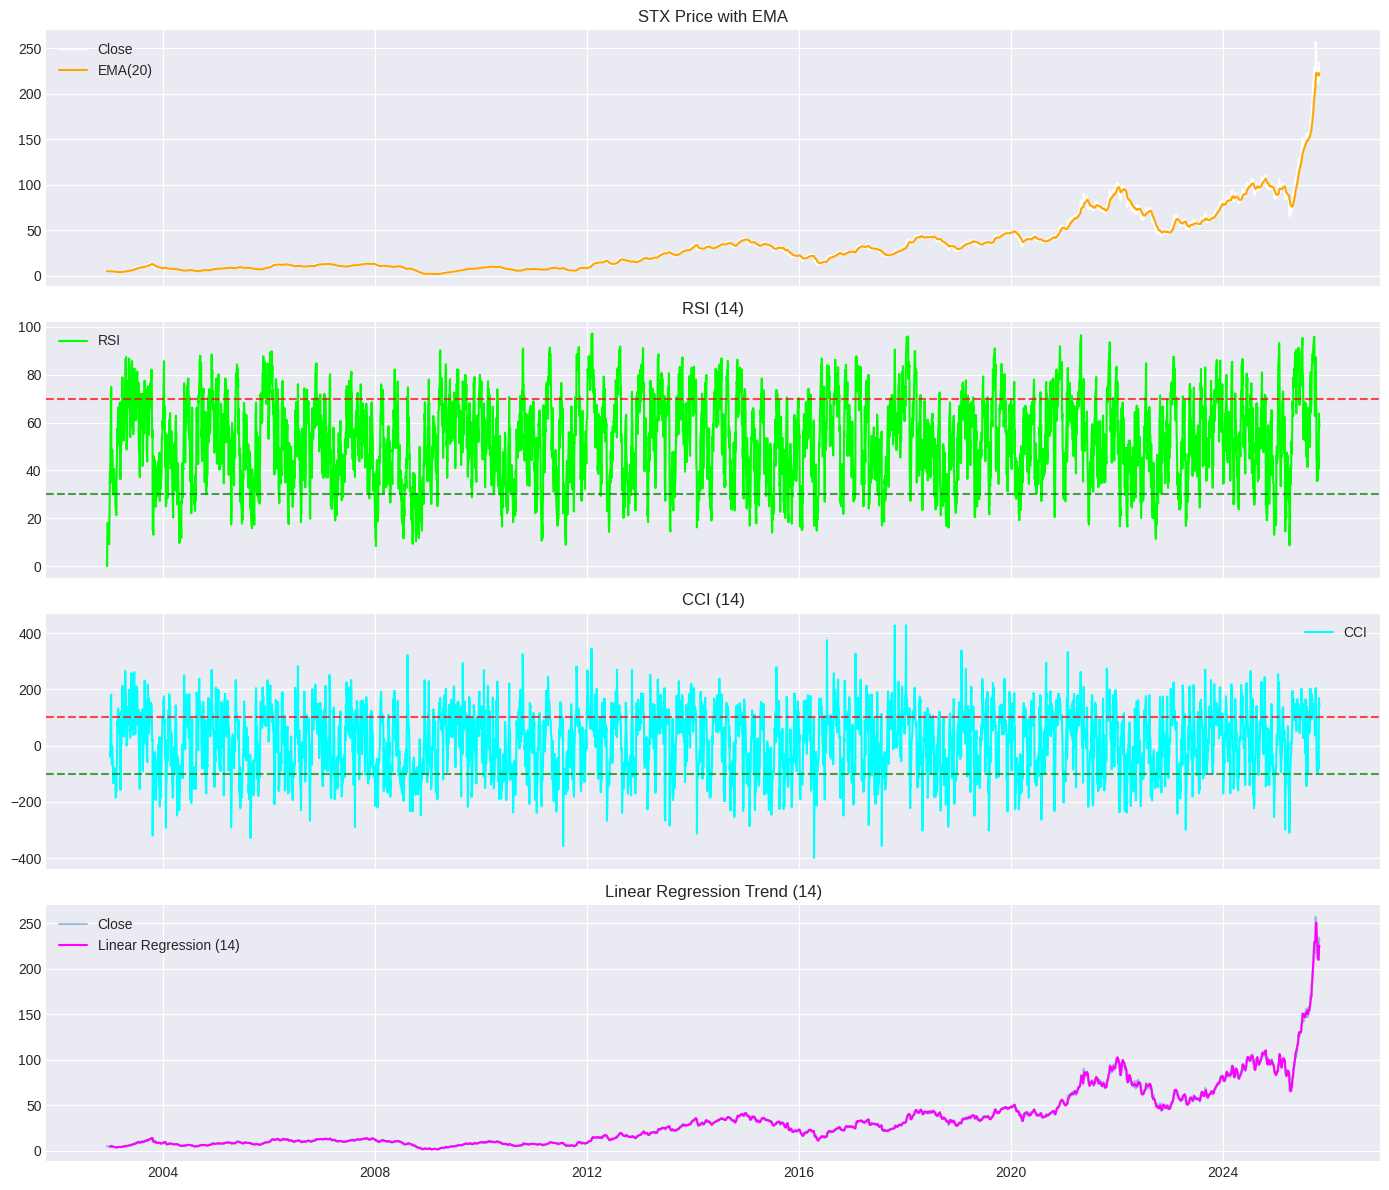

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# -------------------------
# Download Data
# -------------------------
symbol = "STX"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Parameters
# -------------------------
CCI_PERIOD = 14
EMA_PERIOD = 20
LINREG_PERIOD = 14
RSI_PERIOD = 14

# -------------------------
# Indicator Functions
# -------------------------
def calculate_ema(df, period=EMA_PERIOD):
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    return df

def calculate_linreg(series, period=LINREG_PERIOD):
    linreg_values = [np.nan] * len(series)
    for i in range(period - 1, len(series)):
        y = series[i - period + 1:i + 1].values.reshape(-1, 1)
        x = np.arange(period).reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        linreg_values[i] = model.predict([[period - 1]])[0][0]
    return pd.Series(linreg_values, index=series.index)

def calculate_rsi(df, period=RSI_PERIOD):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()
    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

def calculate_cci(df, period=CCI_PERIOD):
    df = df.copy()
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    df['MeanDev'] = df['TP'].rolling(period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df

# -------------------------
# Apply Calculations
# -------------------------
df = calculate_ema(df)
df['LinReg'] = calculate_linreg(df['Close'])
df = calculate_rsi(df)
df = calculate_cci(df)

# -------------------------
# Plotting
# -------------------------
plt.style.use("seaborn-v0_8-darkgrid")
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# --- 1. Price + EMA ---
axes[0].plot(df.index, df['Close'], label='Close', color='white')
axes[0].plot(df.index, df['EMA'], label=f'EMA({EMA_PERIOD})', color='orange')
axes[0].set_title(f"{symbol} Price with EMA")
axes[0].legend()

# --- 2. RSI ---
axes[1].plot(df.index, df['RSI'], label='RSI', color='lime')
axes[1].axhline(70, color='red', linestyle='--', alpha=0.7)
axes[1].axhline(30, color='green', linestyle='--', alpha=0.7)
axes[1].set_title(f"RSI ({RSI_PERIOD})")
axes[1].legend()

# --- 3. CCI ---
axes[2].plot(df.index, df['CCI'], label='CCI', color='cyan')
axes[2].axhline(100, color='red', linestyle='--', alpha=0.7)
axes[2].axhline(-100, color='green', linestyle='--', alpha=0.7)
axes[2].set_title(f"CCI ({CCI_PERIOD})")
axes[2].legend()

# --- 4. Linear Regression Trend ---
axes[3].plot(df.index, df['Close'], label='Close', alpha=0.4)
axes[3].plot(df.index, df['LinReg'], label=f'Linear Regression ({LINREG_PERIOD})', color='magenta')
axes[3].set_title(f"Linear Regression Trend ({LINREG_PERIOD})")
axes[3].legend()

plt.tight_layout()
plt.show()
